## Domain Adaptation by using Wasserstein-2 Generative Networks
USPS dataset features are being transformed to MNIST features by the cycle monotone map. **GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import ot
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from tqdm import tqdm

from IPython.display import clear_output

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from collections import Counter

torch.random.manual_seed(0xBADBEEF)

from src.icnn import DenseICNN
from src.tools import compute_l1_norm, ewma
from src.classifiers import LeNet, train_lenet, test_lenet
from src import distributions

## Config

In [2]:
GPU_DEVICE = 1
BATCH_SIZE = 128
LAMBDA = 1000
L1 = 1e-7

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## Setup Dataloader

In [3]:
extraction = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ColorJitter(0.05, 0.05, 0.05, 0.05),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t + torch.randn((28,28)) * 0.005),
    transforms.Lambda(lambda t: t.clamp(0,1)),
])

mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=extraction)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=extraction)
usps_trainset = datasets.USPS(root='../data', train=True, download=True, transform=extraction)
usps_testset = datasets.USPS(root='../data', train=False, download=True, transform=extraction)

Y_loader = torch.utils.data.DataLoader(
    mnist_trainset, batch_size=BATCH_SIZE,
    shuffle=True, drop_last=True
)

Y_test_loader = torch.utils.data.DataLoader(
    mnist_testset, batch_size=128, shuffle=True
)

X_loader = torch.utils.data.DataLoader(
    usps_trainset, batch_size=BATCH_SIZE,
    shuffle=True, drop_last=True
)

X_test_loader = torch.utils.data.DataLoader(usps_testset, batch_size=128, shuffle=True)

## Training LeNet (feature extractor)

In [4]:
lenet = LeNet()
lenet.cuda()

optimizer = optim.Adam(lenet.parameters(), lr=1e-3)

In [5]:
epochs = 5
for epoch in range(1, epochs + 1):
    train_lenet(lenet, optimizer, epoch, Y_loader, log_interval=100)
    test_lenet(lenet, epoch, Y_test_loader)

Test set, Epoch 1 , Average loss: 0.1468, Accuracy: 9543/10000 (95%)
Test set, Epoch 2 , Average loss: 0.0787, Accuracy: 9750/10000 (98%)
Test set, Epoch 3 , Average loss: 0.0574, Accuracy: 9814/10000 (98%)
Test set, Epoch 4 , Average loss: 0.0646, Accuracy: 9793/10000 (98%)
Test set, Epoch 5 , Average loss: 0.0453, Accuracy: 9849/10000 (98%)


## Extracting features from datasets

In [6]:
def get_lenet_features_from_loader(loader, net):
    dataset = []
    labels = []
    for X_batch, y_batch in loader:
        X_batch_features = net(X_batch.cuda())[1] 
        dataset.append(X_batch_features.detach().cpu().numpy())
        labels.append(y_batch.numpy())
    return np.vstack(dataset), np.hstack(labels)

In [7]:
X_dataset, X_labels = get_lenet_features_from_loader(X_loader, lenet)
X_test_dataset, X_test_labels = get_lenet_features_from_loader(X_test_loader, lenet)
Y_dataset, Y_labels = get_lenet_features_from_loader(Y_loader, lenet)
Y_test_dataset, Y_test_labels = get_lenet_features_from_loader(Y_test_loader, lenet)
        
torch.cuda.empty_cache()

### Fitting PCA for visualization purposes

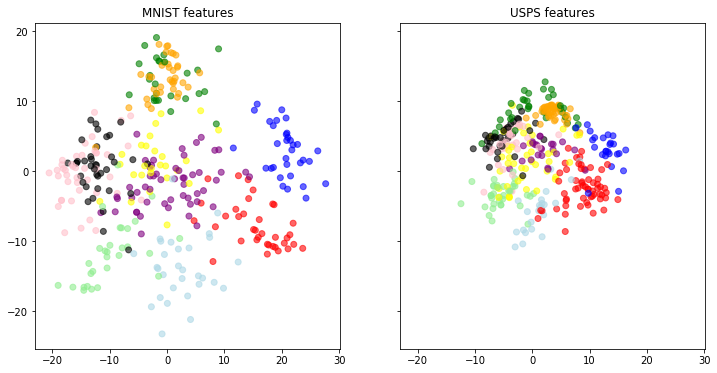

In [8]:
pca = PCA(n_components=2)
pca.fit(Y_dataset)
colors = np.array(['red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'pink', 'purple', 'black'])

X_idx = np.random.choice(range(len(X_dataset)), size=350)
Y_idx = np.random.choice(range(len(Y_dataset)), size=350)

X_enc = pca.transform(X_dataset[X_idx]) 
Y_enc = pca.transform(Y_dataset[Y_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].set_title('MNIST features')
axes[0].scatter(Y_enc[:, 0], Y_enc[:, 1], alpha=0.6, c=colors[Y_labels[Y_idx]])
axes[1].set_title('USPS features')
axes[1].scatter(X_enc[:, 0], X_enc[:, 1], alpha=0.6, c=colors[X_labels[X_idx]])

## kNN setup (metrics)

In [9]:
knn_Y = KNeighborsClassifier(n_neighbors=1)
knn_Y.fit(Y_dataset, Y_labels)
print('MNIST classifier on USPS features score (train):', accuracy_score(knn_Y.predict(X_test_dataset), X_test_labels))

MNIST classifier on USPS features score (train): 0.7344294967613353


## Discrete OT for DA

In [11]:
ot_emd = ot.da.EMDTransport()

# Possible to use train dataset here, but the score will be even smaller!
ot_emd.fit(Xs=X_test_dataset, Xt=Y_test_dataset)

# Test dataset here
X_test_mapped = ot_emd.transform(Xs=X_test_dataset)
print('1-NN Score on Pushed Target', accuracy_score(X_test_labels, knn_Y.predict(X_test_mapped)))

1-NN Score on Pushed Target 0.7428998505231689


## Discriminators Setup

In [12]:
D = DenseICNN(
    84, hidden_layer_sizes=[128, 128, 128],
    activation='celu', dropout=0.001,
    strong_convexity=0.001
).cuda()

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

for p in D.parameters():
    p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 5

97792 parameters in Discriminative Network


### Discriminator Pre-training

In [13]:
noise_sampler = distributions.StandartNormalSampler(dim=84)
pre_D_opt = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.8, 0.99))

D.train(True)
loss_history = []
loss = np.inf

print('Pretraining the discriminator')
for iteration in range(20000):
    X = noise_sampler.sample(BATCH_SIZE) * 4
    X = torch.tensor(X, device='cuda', requires_grad=True, dtype=torch.float)

    loss = ((D.push(X) - X) ** 2).sum(dim=1).mean() + L1 * compute_l1_norm(D)
    
    loss_history.append(loss.item())
    loss.backward()
    pre_D_opt.step()
    pre_D_opt.zero_grad()
    
    D.convexify()
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
    
    if loss.item() < 2*1e-1:
        print('Early stopping at iteration '+ str(iteration))
        break
print('Final Loss:', loss.item())

Pretraining the discriminator for D.push(x)=x
Current loss: 1.348802924156189
Early stopping at iteration 3246
Final Loss: 0.16456472873687744


In [14]:
D_conj = DenseICNN(
    84, hidden_layer_sizes=[128, 128, 128],
    activation='celu', dropout=0.001,
    strong_convexity=0.001
).cuda()

D_conj.load_state_dict(D.state_dict())

<All keys matched successfully>

In [15]:
D_opt = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.8, 0.99))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=1e-4, betas=(0.8, 0.99))

## Main training with Wasserstein-2 distance

In [16]:
X_sampler = distributions.TensorDatasetSampler(X_dataset, storage='cuda', requires_grad=True)
Y_sampler = distributions.TensorDatasetSampler(Y_dataset, storage='cuda', requires_grad=True)

Iteration 10000
1-NN accuracy on mapped train data:  0.8401227678571429
1-NN accuracy on mapped test data:  0.8051818634778276


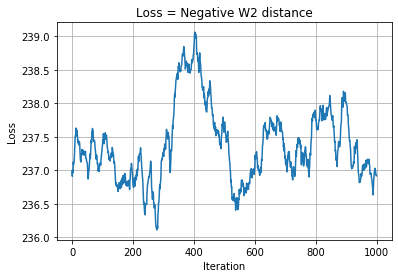

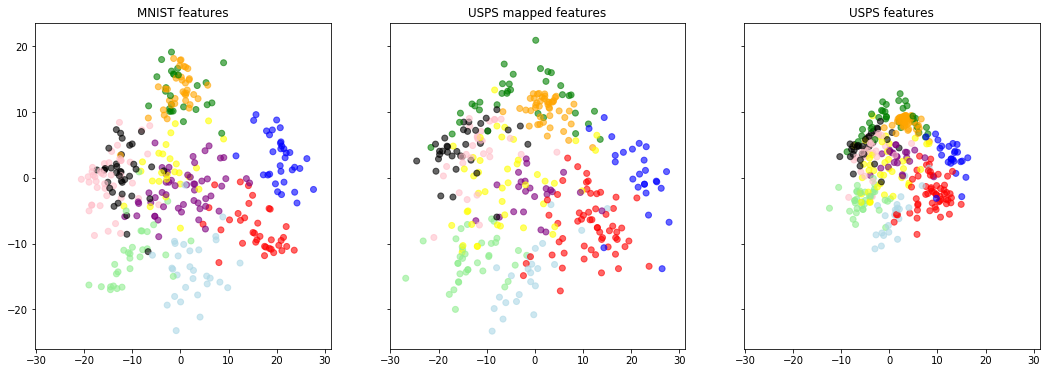

In [18]:
loss_history = []

print('Fitting the monotone generative mapping')
for iteration in range(10000+1):
    D.train(True); D_conj.train(True)
    
    X = X_sampler.sample(BATCH_SIZE)
    Y = Y_sampler.sample(BATCH_SIZE)

    D_cycle_loss = ((D_conj.push(D.push(X)) - X.detach()) ** 2).mean()
    D_conj_cycle_loss = ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean()
    cycle_loss = (D_cycle_loss + D_conj_cycle_loss) / 2

    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad()
    D_conj_opt.zero_grad()
    
    # Negative Wasserstein distance
    W_loss = (D(X) - D(Y_inv)).mean()
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()
    
    D_reg = compute_l1_norm(D)
    D_conj_reg = compute_l1_norm(D_conj)
        
    W_loss += L1 * (D_reg + D_conj_reg)
    W_loss += LAMBDA * cycle_loss
     
    loss_history.append(W_loss.item() + W_loss_nograd.item())

    W_loss.backward()
    D_opt.step(); D_conj_opt.step()
    D_conj_opt.zero_grad(); D_opt.zero_grad()
    D.convexify(); D_conj.convexify()     
        
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Iteration', iteration)
        
        X_mapped_dataset = []
        for i in range(0, len(X_dataset), BATCH_SIZE):
            X = torch.tensor(X_dataset[i:i+BATCH_SIZE], device='cuda', dtype=torch.float32, requires_grad=True)
            X_mapped_dataset.append(D.push(X).cpu().detach().numpy())
        X_mapped_dataset = np.vstack(X_mapped_dataset)
        
        X_mapped_testset = []
        for i in range(0, len(X_test_dataset), BATCH_SIZE):
            X = torch.tensor(X_test_dataset[i:i+BATCH_SIZE], device='cuda', dtype=torch.float32, requires_grad=True)
            X_mapped_testset.append(D.push(X).cpu().detach().numpy())
        X_mapped_testset = np.vstack(X_mapped_testset)

        knn_mapped_score = accuracy_score(X_labels, knn_Y.predict(X_mapped_dataset))
        print('1-NN accuracy on mapped train data: ', knn_mapped_score)
        
        knn_mapped_test_score = accuracy_score(X_test_labels, knn_Y.predict(X_mapped_testset))
        print('1-NN accuracy on mapped test data: ', knn_mapped_test_score)
        
        fig = plt.figure()
        plt.title('Loss = Negative W2 distance')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.plot(ewma(loss_history)[-1000:])
        plt.grid()
        plt.show()
        plt.close(fig)
        
        X_mapped_enc = pca.transform(X_mapped_dataset[X_idx]) 

        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
        axes[0].set_title('MNIST features')
        axes[0].scatter(Y_enc[:, 0], Y_enc[:, 1], alpha=0.6, c=colors[Y_labels[Y_idx]])
        axes[1].set_title('USPS mapped features')
        axes[1].scatter(X_mapped_enc[:, 0], X_mapped_enc[:, 1], alpha=0.6, c=colors[X_labels[X_idx]])
        axes[2].set_title('USPS features')
        axes[2].scatter(X_enc[:, 0], X_enc[:, 1], alpha=0.6, c=colors[X_labels[X_idx]])
        
        plt.show()
        plt.close(fig)